## HR-VPP BETA DATASET VISUALISATION

This notebook is designed to allow plotting of the phenology (VPP) and seasonal trajectories (ST) for a specific point. The option to extract the pixels in a NXN window around the center pixel is also enabled. Note that the mean value of VI's, ST and VPP parameters will be taken for this window extraction.
The notebook can also be used to plot the parameters on polygon level

## Install & import packages
Let's start with installing the Python catalogue client

In [1]:
!pip3 install --user --quiet --index-url=https://artifactory.vgt.vito.be/api/pypi/python-packages/simple --user terracatalogueclient==0.1.12

Next, we import some required packages and initialize the catalogue client. 
The data S2_tile def and py scripts are copied to the tmp folder /home/joyvan to increase performance.
Please read https://www.wekeo.eu/docs/storage-and-python-env for more information

In [2]:
################################################
# IMPORT THE SUPPORTING FUNCTIONS/PACKAGES     #
################################################
import os, sys, shutil, glob
S2_tiles = glob.glob('S2_tiles_EEA39.*')
for file in S2_tiles + ['Supporting_functions_NB_v9.py']:
    shutil.copy(file, os.path.join('/home/jovyan', os.path.basename(file)))
s3_home = os.path.join('/home', os.environ.get('JUPYTERHUB_USER'))

try: sys.path.remove(s3_home)
except Exception: pass
os.chdir('/home/jovyan')

os.environ[ 'MPLCONFIGDIR' ] = '/home/jovyan'
import pandas as pd
import datetime as dt

import logging
from terracatalogueclient import Catalogue
from terracatalogueclient.config import CatalogueConfig
from terracatalogueclient.config import CatalogueEnvironment
config = CatalogueConfig.from_environment(CatalogueEnvironment.HRVPP)
catalogue = Catalogue(config)
sys.path.append(os.getcwd())

#setting up logger (should only be done once)
logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)


from Supporting_functions_NB_v9 import *

os.chdir(s3_home)
sys.path.append(s3_home)

#standard level should be logging.WARNING, logging.INFO will give some extra info  (logging.DEBUG can also be used however should be used with an output log file)
logger.setLevel(logging.INFO)



proj_create: Open of /opt/conda/share/proj failed
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: Open of /opt/conda/share/proj failed
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


### CREDENTIALS
##### This part manages the credentials of the access to the data
First, provide your wekeo password in the password widget and press ENTER

In [3]:
import ipywidgets as widgets

valid_output = widgets.Valid(value=False)

def on_submit_func(button):
    button.disabled=True
    valid_output.value=True

pwd_input = widgets.Password(value='password',
                             placeholder='Enter password',
                             description='Password:',
                             disabled=False)

pwd_input.on_submit(on_submit_func)

left_box = widgets.VBox([pwd_input])
right_box = widgets.VBox([valid_output])
widgets.HBox([left_box, right_box])


Creating credentials and pinpoint to a writeable adress for the header_file (This file is created and used to request data via https, is not persistent over sessions)

In [4]:
credentials = [os.environ.get('JUPYTERHUB_USER'),'880803']
               #pwd_input.value]
header_file = os.path.join('/home/jovyan','header_file.txt')

### PLOT INTERACTIVE MAP
##### ON THIS MAP YOU CAN CLICK ON A LOCATION OF INTEREST. THE COORDINATES OF YOUR SELECTION ARE STORED IN THE LOG CONSOLE COPIED AUTOMATICALLY TO COORDINATES TO ENABLE PLOTTING OF THE VIs & ST. IF THE COORDINATES OF THE POINT ARE KNOWN OR A SHAPEFILE IS TO BE USED, IT CAN BE SET MANUALLY IN THE NEXT BLOCK

In [5]:
def handle_click(**kwargs):
    global ll 
    if kwargs.get('type') == 'click':
        ll = kwargs.get('coordinates')
        interactive_map.add_layer(Marker(location=kwargs.get('coordinates')))
        print("Selected pixel with LATITUDE {} and LONGITUDE {}".format(ll[0],ll[1]))
        
interactive_map = create_interactive_map(center = [50,5.1])
display(interactive_map)
interactive_map.on_interaction(handle_click)

proj_create: Open of /opt/conda/share/proj failed
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
2022-11-09 14:35:30,839 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


Map(center=[50, 5.1], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

### SETUP PARAMETERS
Define the point (lat,lon) for which you want to plot the ST & VPP (automatically imported from map or set manually) or set a shapefile to extract data from. If preferred you can define a NxN window around the pixel.

In [6]:
#set window size if a shapefile is to be used set window size =0
NxN_window = 0

# if shapefile is to be used put here the name of the shapefile
#shapefile should be in EPSG:4326
shapefile = 'Fields'

#lat,lon of the point this is taken from the map or can be set manually
#pixel_lat, pixel_lon = ll[0],ll[1]    #from interactive map selection
pixel_lat, pixel_lon = 49.9870229366118 , 6.767578125000001 # manually set


if NxN_window == 0:
    shapefiles = glob.glob(os.path.join(s3_home,shapefile+'.*'))
    print(f'extraction for shapefile {shapefile}')
    for file in shapefiles:
        shutil.copy(file, os.path.join('/home/jovyan', os.path.basename(file)))
    shape = os.path.basename(shapefile)  + '.shp'
    tile, xoff, yoff = get_centroid(shape)
    

else :
    print('Selected pixel at LATITUDE {} , LONGITUDE {}'.format(pixel_lat,pixel_lon))
    tile, xoff, yoff = latlon_to_S2(pixel_lat, pixel_lon)
    shape = None


extraction for shapefile Fields
Point found in tile 31UFS at col 6155 line 5450


proj_create: Open of /opt/conda/share/proj failed
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


### ADDITIONAL SETTINGS
Here additional setting can be handled (not geometry related) as a simple bloxplot is generated to have an idea on the data.

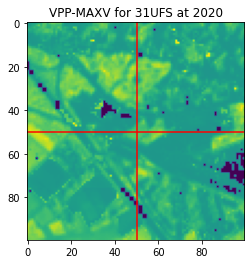

In [7]:
## version number only v01
version = 'v01'

## years for which you want to extract VPP data (options between 2017-2020, should be consecutive)
years = ['2017','2018','2019','2020','2021'] 

## enable to get also the raw (basic) PPI series
option_PPI = False
## enable to get also th raw NDVI series
option_NDVI = False

# plot VPP-parameter of pixel and surrounding area where parameter is a VPP product 
#that is extracted for year YEAR and in a bounding box of 100 pixels. 
#For polygon extraction the centroid is used as center pixel

plot_box(header_file, credentials, config, catalogue, version, tile, xoff, yoff, parameter = 'MAXV', year=2020, box=100)

## EXTRACT THE DATA FROM WEKEO 
Data is extracted from wekeo. if the extraction is not a single point the median vover the values will be computed.

In [8]:
###### CREATE CLASSES FOR VI AND PHENO extraction
VI_ex = VI_class(header_file, credentials, config, catalogue, version, tile, xoff, yoff, NxN_window, shape,  option_PPI, option_NDVI)
phenology_ex = phenology_class(header_file, credentials, config, catalogue, version, tile, xoff, yoff, NxN_window, shape, years)

#### LOADING DATA FROM WEKEO
print('*** Extracting data from WEKEO - this can take several minutes, so be patient !! **')
phenology_ex.extract_phenology_data()

if option_PPI or option_NDVI:
    VI_ex.load_and_store_vi_data()

*** Extracting data from WEKEO - this can take several minutes, so be patient !! **
EXTRACTING ST DATA FOR YEARS: 2017 - 2021


proj_create: Open of /opt/conda/share/proj failed
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


(10, 12)
(180, 10, 12)
EXTRACTING VPP DATA FOR YEARS: 2017 - 2021
... in 0.5658428072929382 mins
EXTRACTION FINISHED


### STORE THE EXTRACTION IN A DATAFRAME

The ST and VPP parameters will be stored in a pandas dataframe to allow easy plotting. 

In [9]:
#### CONVERT EXTRACTS TO PANDAS ###
phenology_ex.VPP_to_df()
if option_PPI or option_NDVI:
    VI_ex.VI_to_df()
    

#### PRINT & PLOT THE EXTRACTED VPP & ST PARAMETERS 



 sos DOY (first season) for 2017 at : 2017-05-23 00:00:00
 max DOY (first season) for 2017 at : 2017-07-14 00:00:00
 eos DOY (first season) for 2017 at: 2017-10-10 00:00:00

 sos DOY (first season) for 2018 at : 2018-03-26 00:00:00
 max DOY (first season) for 2018 at : 2018-06-02 00:00:00
 eos DOY (first season) for 2018 at: 2018-08-13 00:00:00

 sos DOY (second season) for 2018 at : 2018-08-26 00:00:00
 max DOY (second season) for 2018 at: 2018-09-27 00:00:00
 eos DOY (second season) for 2018 at : 2018-11-09 00:00:00

 sos DOY (first season) for 2019 at : 2019-03-06 00:00:00
 max DOY (first season) for 2019 at : 2019-05-18 00:00:00
 eos DOY (first season) for 2019 at: 2019-08-13 00:00:00

 sos DOY (second season) for 2019 at : 2019-08-21 00:00:00
 max DOY (second season) for 2019 at: 2019-10-02 00:00:00
 eos DOY (second season) for 2019 at : 2019-11-25 00:00:00

 sos DOY (first season) for 2020 at : 2020-02-27 00:00:00
 max DOY (first season) for 2020 at : 2020-05-20 00:00:00
 eos D

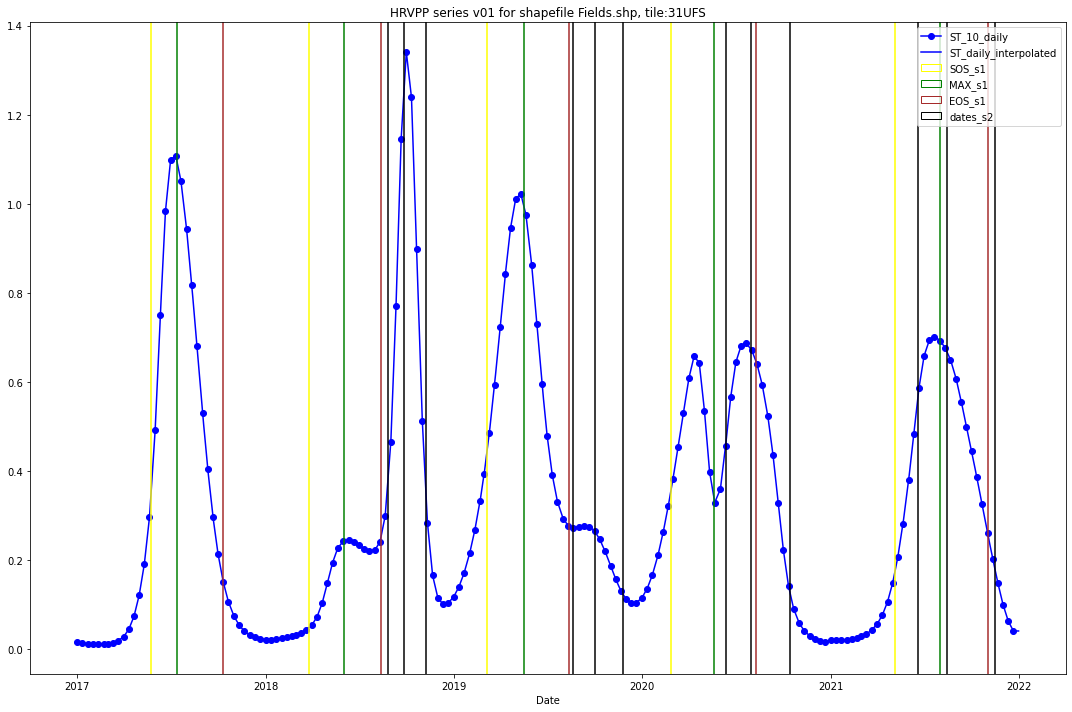

In [10]:
### print the dates of the VPP pararms for the extracted region
phenology_ex.print_VPP_params()
VI_ex = VI_class(header_file, credentials, config, catalogue, version, tile, xoff, yoff, NxN_window, shape,  option_PPI, option_NDVI)
### function to plot the extracted VPP pararms for the extracted pixels together with the extracted VI's and STs
## Plottting of VI's can be toggled off by setting VI_ex.option_PPI/VI_ex.option_NDVI = False 


plot_VPP_ST(phenology_ex, VI_ex, (pixel_lat, pixel_lon, NxN_window), outdir = s3_home, save_plot = False) 